# Coursework 3 Streaming Algorithm

## **Task1：DGIM**

DGIM is an efficient algorithm in processing large streams. When it's infeasible to store the flowing binary stream, DGIM can estimate the number of 1-bits in the window. In this coding, you're given the stream_data_dgim.txt (binary stream), and you need to implement the DGIM algorithm to count the number of 1-bits. Write code below.

### 1. Set the window size to 1000, and count the number of 1-bits in the current window.

In [102]:
from typing import List, Dict
from collections import defaultdict, deque

class Bucket():
    def __init__(self, time_stamp, order=0):
        self.time_stamp = time_stamp
        self.order = order  # bucket contains (2 ** order) 1's


class DGIM():
    def __init__(self, window_size, n_bins=2):
        self.window_size = window_size
        self.buckets: Dict[int, deque[Bucket]] = defaultdict(deque)
        self.ticker = 0
        self.n_bins = n_bins

    def consume_next(self, item):
        assert item == 0 or item == 1, f"Invalid stream item {item}"
        if item == 1:
            self.buckets[0].append(Bucket(self.ticker))
            self._update_buckets()
        self.ticker += 1

    def count_ones(self, bits):
        for b in bits:
            self.consume_next(b)
        return self.query(self.window_size)

    def query(self, window_size):
        counts = 0
        previous_order = 0
        for order, bucket_list in self.buckets.items():
            for bucket in reversed(bucket_list):  # backward along time
                # print(order, bucket.time_stamp)
                if self._in_window(bucket.time_stamp, window_size):
                    # count 1's in valid window
                    counts += 2 ** order
                else:
                    # early stop if window timed out
                    counts -= 2 ** (previous_order - 1)
                    return counts
                previous_order = order
        # remove half of last window
        counts -= 2 ** (previous_order - 1)
                
        return counts
        
    def _in_window(self, t, window_size):
        return self.ticker - t < window_size
    
    def _update_buckets(self):
        order = 0

        # merge bins
        while order < len(self.buckets.values()):
            count = len(self.buckets[order])
            if count > self.n_bins:
                _ = self.buckets[order].popleft()  # oldest
                second = self.buckets[order].popleft()  # second oldest
                merged = Bucket(second.time_stamp, order + 1)
                self.buckets[order+1].append(merged)
            order += 1

        # discard outdated windows
        order = max(self.buckets.keys())
        length = len(self.buckets[order])
        idx = 0
        while idx < length:
            item = self.buckets[order].popleft()
            if self._in_window(item.time_stamp, self.window_size):
                self.buckets[order].append(item)
            idx += 1
        if not self.buckets[order]:
            # remove empty list of buckets
            self.buckets.pop(order)


WINDOW_SIZE = 1000
solver = DGIM(WINDOW_SIZE, n_bins=2)

with open('./stream_data_dgim.txt', 'r') as stream:
    bits = stream.read(-1).split('\t')

bits = list(map(int, bits[:-1]))
count = solver.count_ones(bits)
print("1's in the last 1000 bits:", count)



1's in the last 1000 bits: 508


### 2. With the window size 1000, count the number of 1-bits in the last 500 and 200 bits of the bitstream.

In [103]:
print("1's in the last 500 bits:", solver.query(500))
print("1's in the last 200 bits:", solver.query(200))

1's in the last 500 bits: 220
1's in the last 200 bits: 76


### 3. Write a function that accurately counts the number of 1-bits in the current window. Caculate the accuracy of your own DGIM algorithm and compare the running time difference.

In [107]:
import time

# DGIM
solver = DGIM(WINDOW_SIZE)
solver.count_ones(bits)

# only compute query time (because the window is too small)
time_start = time.perf_counter()
res = solver.query(WINDOW_SIZE)
time_end = time.perf_counter()
time_elapsed = (time_end - time_start) * 1000
print(f'DGIM query time: {time_elapsed:.4f}ms')

# ground truth
time_start = time.perf_counter()
gt = sum(bits[-WINDOW_SIZE:])
time_end = time.perf_counter()
time_elapsed = (time_end - time_start) * 1000
print(f'GT query time: {time_elapsed:.4f}ms')

# Relative Error
err = abs(res - gt) / gt * 100
print(f'Relative err: {err:.3f}')

DGIM query time: 0.0604ms
GT query time: 0.0598ms
Relative err: 29.923


## **Task2: Bloom Filter**

A Bloom filter is a space-efficient probabilistic data structure. Here the task is to implement a bloom filter by yourself. 

### Data loading:

From the NLTK (Natural Language ToolKit) library, we import a large list of English dictionary words, commonly used by the very first spell-checking programs in Unix-like operating systems.

In [110]:
import nltk
from nltk.corpus import words
nltk.download('words')
word_list = words.words()

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\YBR10\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


Then we load another dataset from the NLTK Corpora collection: movie_reviews.

The movie reviews are categorized between positive and negative, so we construct a list of words (usually called bag of words) for each category.

In [133]:
from nltk.corpus import movie_reviews
nltk.download('movie_reviews')

neg_reviews = []
pos_reviews = []

for fileid in movie_reviews.fileids('neg'):
    neg_reviews.extend(movie_reviews.words(fileid))
for fileid in movie_reviews.fileids('pos'):
    pos_reviews.extend(movie_reviews.words(fileid))

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\YBR10\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


Here we get a data stream (word_list) and 2 query lists (neg_reviews and pos_reviews).

### 1. Write a function that accurately determines whether each word in neg_reviews and pos_reviews belongs to word_list.

In [158]:
def gt_counter(reviews, word_list):
    gts = []
    for word in reviews:
        if word in word_list:
            gts.append(True)
        else:
            gts.append(False)

    return gts


def accurate_count_reviews(pos_reviews, neg_reviews, word_list):
    pos_gts = gt_counter(pos_reviews, word_list)
    neg_gts = gt_counter(neg_reviews, word_list)
    return pos_gts, neg_gts

pos_gts, neg_gts = accurate_count_reviews(pos_reviews, neg_reviews, set(word_list))
print(len(pos_gts), sum(pos_gts))
print(len(neg_gts), sum(neg_gts))

832564 600128
751256 540998


 ### 2. Implement the bloom filter by yourself and add all words in word_list in your bloom filter. Compare the running time difference between linear search on a list and multiple hash computations in a Bloom filter.

In [170]:
import string    
import random
import numpy as np

STRING_LIB = string.ascii_uppercase + string.ascii_lowercase + string.digits


class Hasher():
    def __init__(self, n_bits, n_hashes=10, N=20):
        self.n_hashes = n_hashes
        self.n_bits = n_bits
        self.N = N
        self.hashes = []
        for _ in range(self.n_hashes):
            self.hashes.append(''.join(random.choices(STRING_LIB, k = self.N)))

    def hash(self, word):
        assert self.n_hashes >= 1, "?"
        hashed = []
        for h in self.hashes:
            hashed.append(int(hash(h + word) % self.n_bits))

        if self.n_hashes > 1:
            return hashed
        elif self.n_hashes == 1:
            return hashed[0]


class Bloom():
    def __init__(self, database, n_bits=1000000, n_hashes=4):
        self.database = database
        self.size = len(database)
        self.n_bits = n_bits
        self.hasher = Hasher(n_bits, n_hashes=n_hashes)
        self.hashed_string = np.zeros(self.n_bits, dtype=np.bool8)
        for i in range(self.size):
            hashed = self.hasher.hash(database[i])
            for h in hashed:
                self.hashed_string[h] = True
        
    def sweep(self, word):
        hashed_word = self.hasher.hash(word)
        for h in hashed_word:
            if self.hashed_string[h] != True:
                return False
        return True

    def sweep_all(self, words):
        hits = []
        for word in words:
            if self.sweep(word):
                hits.append(True)
            else:
                hits.append(False)

        return hits



In [160]:
bloom = Bloom(word_list)
start_time = time.perf_counter()
pos_preds = bloom.sweep_all(pos_reviews)
neg_preds = bloom.sweep_all(neg_reviews)
end_time = time.perf_counter()
time_elapsed = (end_time - start_time)

print(f'Bloom filter time cost: {time_elapsed:.4f}s')

Bloom filter time cost: 8.6094s


In [161]:
def calc_fpr(preds, gts):
    fp = 0
    tn = 0
    for pred, gt in zip(preds, gts):
        if not gt:
            # not in gt
            if not pred:
                tn += 1
            else:
                fp += 1
    return fp / (fp + tn)

pos_fpr = calc_fpr(pos_preds, pos_gts) * 100
neg_fpr = calc_fpr(neg_preds, neg_gts) * 100
print(f'pos_reviews FPR: {pos_fpr:.2f}%; neg_previews FPR {neg_fpr:.2f}%')

pos_reviews FPR: 6.05%; neg_previews FPR 5.78%


### 3. Use different bit array length ‘m’ and number of hash functions ‘k’ to implement the bloom filter algorithm. Then compare the impact of different m and k on the false positive rate.

m: 10000; pos_reviews FPR: 100.00%; neg_previews FPR 100.00%
m: 50000; pos_reviews FPR: 100.00%; neg_previews FPR 100.00%
m: 100000; pos_reviews FPR: 100.00%; neg_previews FPR 100.00%
m: 500000; pos_reviews FPR: 55.35%; neg_previews FPR 57.54%
m: 1000000; pos_reviews FPR: 24.56%; neg_previews FPR 25.97%
m: 5000000; pos_reviews FPR: 0.12%; neg_previews FPR 0.10%
m: 10000000; pos_reviews FPR: 0.00%; neg_previews FPR 0.00%
k: 2; pos_reviews FPR: 14.14%; neg_previews FPR 14.65%
k: 3; pos_reviews FPR: 15.02%; neg_previews FPR 15.72%
k: 4; pos_reviews FPR: 7.76%; neg_previews FPR 7.97%
k: 6; pos_reviews FPR: 8.38%; neg_previews FPR 8.22%
k: 8; pos_reviews FPR: 33.80%; neg_previews FPR 35.10%
k: 10; pos_reviews FPR: 34.18%; neg_previews FPR 35.59%


<ipython-input-165-a2f7aa31b5ab>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(Ks)


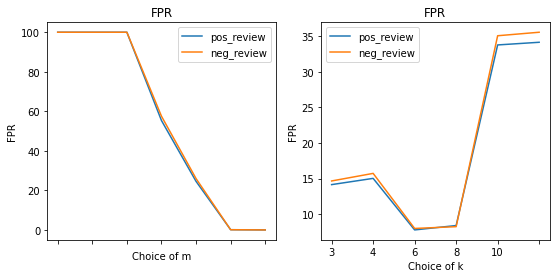

In [165]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

Ms = [10000, 50000, 100000, 500000, 1000000, 5000000, 10000000]
Ks = [2, 3, 4, 6, 8, 10]

pos_fprs = []
neg_fprs = []
for m in Ms:
    bloom = Bloom(word_list, n_bits=m)
    pos_preds = bloom.sweep_all(pos_reviews)
    neg_preds = bloom.sweep_all(neg_reviews)
    pos_fpr = calc_fpr(pos_preds, pos_gts) * 100
    neg_fpr = calc_fpr(neg_preds, neg_gts) * 100
    print(f'm: {m}; pos_reviews FPR: {pos_fpr:.2f}%; neg_previews FPR {neg_fpr:.2f}%')
    pos_fprs.append(pos_fpr)
    neg_fprs.append(neg_fpr)
ax[0].plot(pos_fprs, label='pos_review')
ax[0].plot(neg_fprs, label='neg_review')
ax[0].set_title('FPR')
ax[0].set_xlabel('Choice of m')
ax[0].set_xticklabels([])
ax[0].set_ylabel('FPR')
ax[0].legend()

pos_fprs = []
neg_fprs = []
for k in Ks:
    bloom = Bloom(word_list, n_hashes=k)
    pos_preds = bloom.sweep_all(pos_reviews)
    neg_preds = bloom.sweep_all(neg_reviews)
    pos_fpr = calc_fpr(pos_preds, pos_gts) * 100
    neg_fpr = calc_fpr(neg_preds, neg_gts) * 100
    print(f'k: {k}; pos_reviews FPR: {pos_fpr:.2f}%; neg_previews FPR {neg_fpr:.2f}%')
    pos_fprs.append(pos_fpr)
    neg_fprs.append(neg_fpr)
ax[1].plot(pos_fprs, label='pos_review')
ax[1].plot(neg_fprs, label='neg_review')
ax[1].set_title('FPR')
ax[1].set_xlabel('Choice of k')
ax[1].set_xticklabels(Ks)
ax[1].set_ylabel('FPR')
ax[1].legend()

## **Task3: Statistics Estimation**

Here we use the query stream (neg_reviews) from task 2 to estimate 1) the number of distinct words appeared, and 2)the surprise number of the stream.

### 1. 	Write a function that accurately counts the occurrence times of each word in neg_reviews.

In [174]:
from collections import Counter
neg_word_counts = Counter(neg_reviews)
print(len(neg_word_counts.keys()))

28480


### 2. Implement the Flajolet-Martin alg. to estimate the number of distinct words occurred. Try multiple hash functions to improve the estimate.

In [208]:
def flajolet_martin_single_shot(words, hasher):
    max_r = 0
    for word in words:
        hashed = hasher.hash(word)
        r = hashed & (-hashed)
        if r > max_r:
            max_r = r
    return max_r


def flajolet_martin_multi_hash(words, n_bits, n_hashes, n_groups=4):
    hashers = []
    for i in range(n_hashes):
        hashers.append(Hasher(n_bits, n_hashes=1))
    res = []
    for h in hashers:
        res.append(flajolet_martin_single_shot(words, h))

    # mean of medians
    step_size = n_hashes // n_groups
    medians = []
    for i in range(n_groups):
        medians.append(np.median(res[i*step_size:(i+1)*step_size]))
    
    return np.mean(medians)

alice_the_hasher = Hasher(2**30, n_hashes=1)
sing_res = flajolet_martin_single_shot(neg_reviews, alice_the_hasher)
print(f'Sigle hash: {sing_res}')
mult_res = flajolet_martin_multi_hash(neg_reviews, 2**30, n_hashes=12)
print(f'Multi hash: {mult_res:.2f}')
    

Sigle hash: 2097152
Multi hash: 61440.00


### 3.Estimate the surpise number with limited memory to store words.

In [227]:
def ams_method(words, n_randvars):
    n = len(words)
    Xs = np.random.randint(0, n, (n_randvars,))
    Xs = set(list(Xs))
    counter = defaultdict(int)
    appears = defaultdict(int)
    for idx, word in enumerate(words):
        if idx in Xs:
            appears[word] += 1
        if word in appears:
            counter[word] += appears[word]

    return 2 * n * (np.sum(list(counter.values())) / len(Xs)) - n_randvars
        

gt = np.sum(np.array(list(neg_word_counts.values())).astype(np.float32) ** 2)
print(f'Ground truth: {gt:.2f}')
pred = ams_method(neg_reviews, 10000)
print(f'Pred        : {pred:.2f}')

Ground truth: 5896116224.00
Pred        : 5870278496.89
